# Jupyter Notebook for Task 4: Modeling

#### Preparation

In [29]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

aggregated_data = pd.read_pickle(os.path.join('Data', 'aggregated_data.pkl'))
aggregated_data.head()

,activeSessions_site1,utilizationRate_site1,kWhDelivered_site1,idleRate_site1,blockedRate_site1,activeSessions_site2,utilizationRate_site2,kWhDelivered_site2,idleRate_site2,blockedRate_site2,...,cloud_cover_description,pressure,windspeed,precipitation,hour_of_day,week_of_year,day_of_week,month_of_year,is_weekend,date
start_hour,,,,,,,,,,,,,,,,,,,,,
2018-04-25 04:00:00-07:00,0,0.0,0.0,0.0,0.0,1,0.015737,3.118359,1.000000,0.000000,...,Partly Cloudy,987.47,7.0,0.0,4,17,2,4,False,2018-04-25
2018-04-25 05:00:00-07:00,0,0.0,0.0,0.0,0.0,1,0.018182,3.602725,1.000000,0.000000,...,Partly Cloudy,987.80,15.0,0.0,5,17,2,4,False,2018-04-25
2018-04-25 06:00:00-07:00,0,0.0,0.0,0.0,0.0,3,0.014899,3.170394,1.000000,0.000000,...,Fair,988.45,9.0,0.0,6,17,2,4,False,2018-04-25
2018-04-25 07:00:00-07:00,0,0.0,0.0,0.0,0.0,7,0.058298,12.224048,0.957030,0.002505,...,Fair,988.78,13.0,0.0,7,17,2,4,False,2018-04-25
2018-04-25 08:00:00-07:00,0,0.0,0.0,0.0,0.0,22,0.248985,36.984350,0.926976,0.018182,...,Fair,988.78,13.0,0.0,8,17,2,4,False,2018-04-25


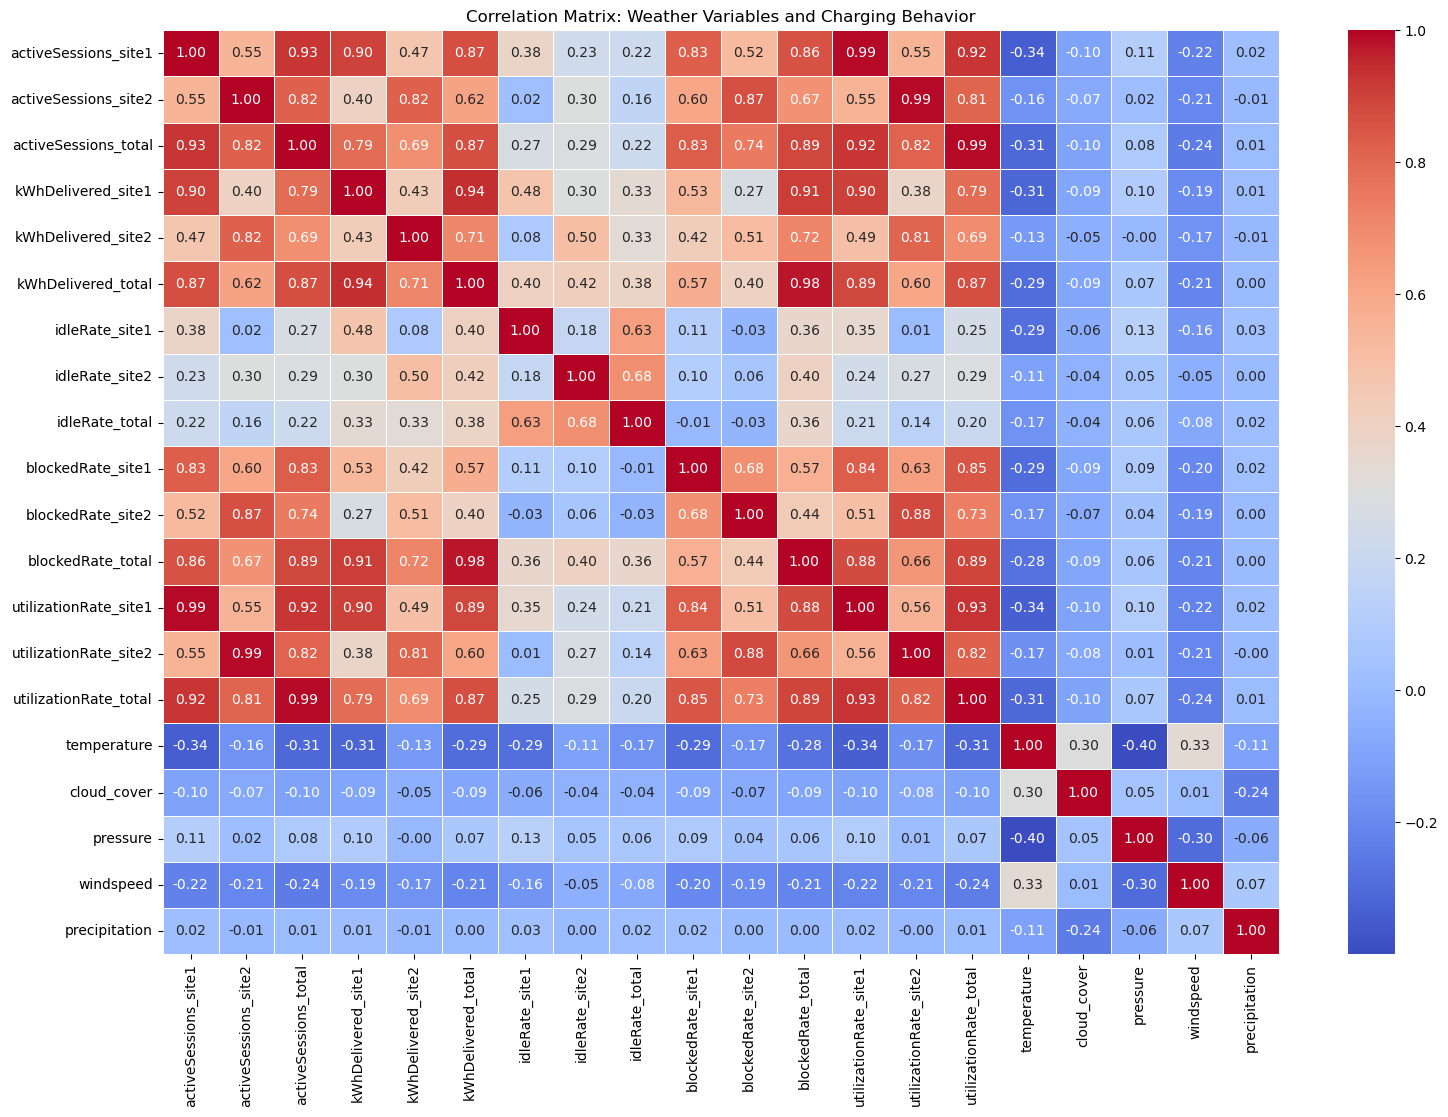

In [30]:
# Compute the correlation matrix
correlation_matrix = aggregated_data[
    ['activeSessions_site1', 'activeSessions_site2', 'activeSessions_total', 'kWhDelivered_site1', 'kWhDelivered_site2',
     'kWhDelivered_total', 'idleRate_site1', 'idleRate_site2', 'idleRate_total', 'blockedRate_site1', 'blockedRate_site2', 'blockedRate_total', 'utilizationRate_site1', 'utilizationRate_site2', 'utilizationRate_total', 'temperature', 'cloud_cover',
     'pressure', 'windspeed', 'precipitation']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix: Weather Variables and Charging Behavior')
plt.show()

## 1 Data Prep & Cross Validation

Before developing different models for predicting hourly utilization of the sites, we will divide the `aggregated_data` from Task 2 into training and holdout sets. This partitioning is essential for obtaining an unbiased estimate of model performance on unseen data.

In [31]:
# Select 'utilizationRate_total' column from the DataFrame
aggregated_data = aggregated_data[['kWhDelivered_total']]  # This keeps it as a DataFrame, not a Series

aggregated_data.index = pd.to_datetime(aggregated_data.index)
aggregated_data = aggregated_data[aggregated_data.index.year == 2021]

aggregated_data.index.freq = 'H'

aggregated_data['kWhDelivered_total'].replace(0, np.nan, inplace=True)
aggregated_data['kWhDelivered_total'].fillna(method='bfill', inplace=True)
aggregated_data['kWhDelivered_total'].fillna(method='ffill', inplace=True)

aggregated_data.index = pd.to_datetime(aggregated_data.index).tz_localize(None)

aggregated_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6152 entries, 2021-01-01 00:00:00 to 2021-09-14 08:00:00
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   kWhDelivered_total  6152 non-null   float64
dtypes: float64(1)
memory usage: 96.1 KB


C:\Users\paull\AppData\Local\Temp\ipykernel_24528\4137211805.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aggregated_data.index.freq = 'H'
C:\Users\paull\AppData\Local\Temp\ipykernel_24528\4137211805.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  aggregated_data['kWhDelivered_total'].replace(0, np.nan, inplace=True)
C:\Users\paull\AppData\Local\Temp\ipykernel_24528\4137211805.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series th

In [32]:
from sklearn.model_selection import train_test_split

# # Cross Validation for utilizationRate_site1
# train_X_ur1, test_X_ur1, train_y_ur1, test_y_ur1 = train_test_split(
#     aggregated_data[['hour_of_day', 'week_of_year', 'day_of_week',
#        'month_of_year', 'is_weekend', 'temperature', 'cloud_cover', 'pressure', 'windspeed', 'precipitation']],
#     aggregated_data[['utilizationRate_site1']], test_size=0.3)
#
# # Cross Validation for utilizationRate_site2
# train_X_ur2, test_X_ur2, train_y_ur2, test_y_ur2 = train_test_split(
#     aggregated_data[['hour_of_day', 'week_of_year', 'day_of_week',
#        'month_of_year', 'is_weekend', 'temperature', 'cloud_cover', 'pressure', 'windspeed', 'precipitation']],
#     aggregated_data[['utilizationRate_site2']], test_size=0.3)
#
# # Cross Validation for kWhDelivered_total
# train_X_kWh, test_X_kWh, train_y_kWh, test_y_kWh = train_test_split(
#     aggregated_data[['hour_of_day', 'week_of_year', 'day_of_week',
#        'month_of_year', 'is_weekend', 'temperature', 'cloud_cover', 'pressure', 'windspeed', 'precipitation']],
#     aggregated_data[['kWhDelivered_total']], test_size=0.3)

# end_date = pd.Timestamp('2021-07-01', tz='UTC')
#
# # Cross Validation for kWhDelivered_total
# train_X_kWh = aggregated_data[['kWhDelivered_total']].loc[start_date:end_date]
# test_X_kWh = aggregated_data[['kWhDelivered_total']].loc[end_date:]

#Data Prep
start_date = pd.Timestamp('2020-11-19', tz='UTC')

relevant_data_kWh = aggregated_data[['kWhDelivered_total']].loc[start_date:]
data_length = len(relevant_data_kWh)
# Index für die Aufteilung in Train und Test berechnen (80% Train, 20% Test -> Holdout in Exercise)
train_end_index = int(data_length * 0.8)

train_X_kWh = relevant_data_kWh.iloc[:train_end_index]
test_X_kWh = relevant_data_kWh.iloc[train_end_index:]


TypeError: Cannot compare tz-naive and tz-aware datetime-like objects.

***

## 2 ARIMA Model
### 2.1 Log

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5753 entries, 2020-11-18 16:00:00-08:00 to 2021-07-16 09:00:00-07:00
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   kWhDelivered_total  5753 non-null   float64
dtypes: float64(1)
memory usage: 89.9 KB


c:\Users\paull\anaconda3\envs\DynamoData\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


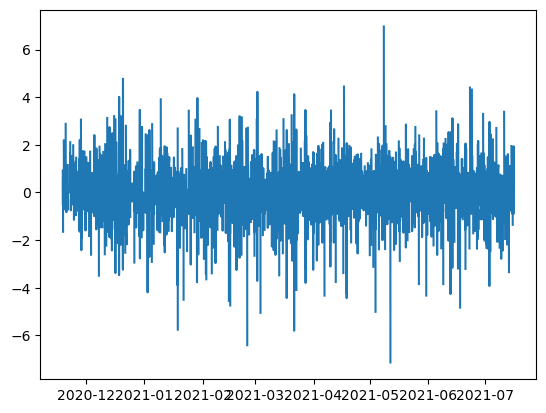

In [ ]:
train_X_kWh.info()
train_X_kWh_log = np.log(train_X_kWh['kWhDelivered_total'])

train_X_kWh_log.shift(periods=1)
ts_log_diff = train_X_kWh_log - train_X_kWh_log.shift()
plt.plot(ts_log_diff)

### 2.1 Decompositioning

In [17]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=168).mean()
    rolstd = timeseries.rolling(window=168).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:\n')
    dftest = adfuller(timeseries, maxlag=168, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = "{:,.4f}".format(value)  # Change the format specifier here
    print(dfoutput)

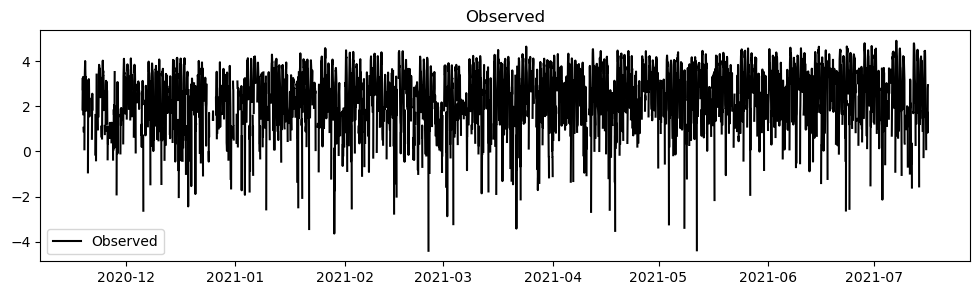

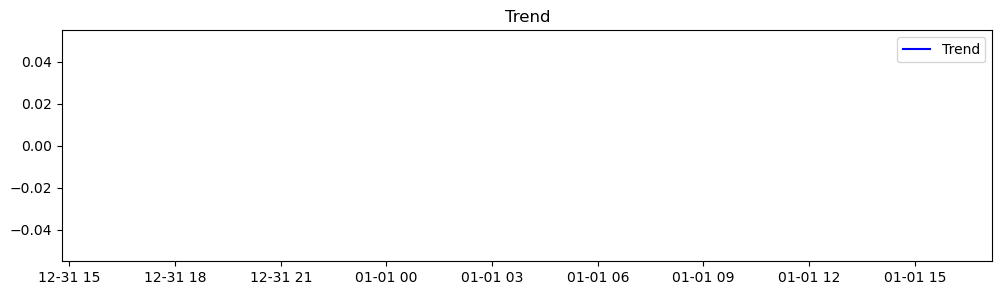

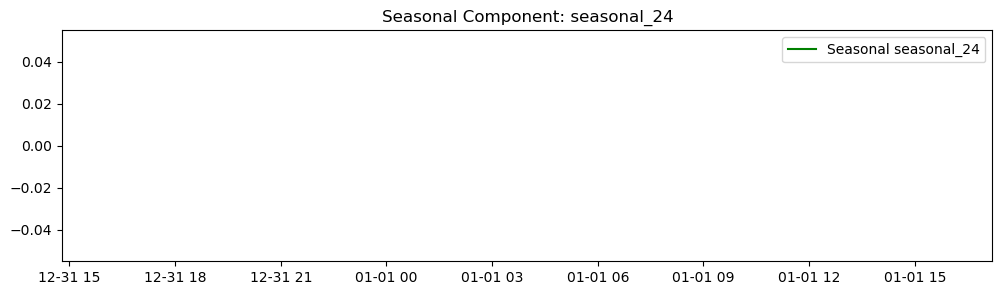

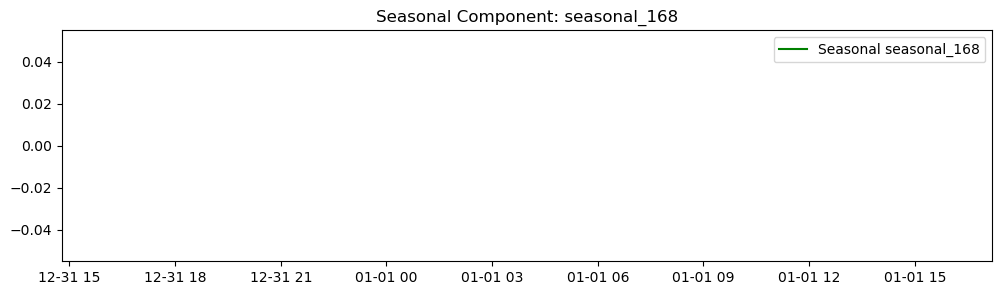

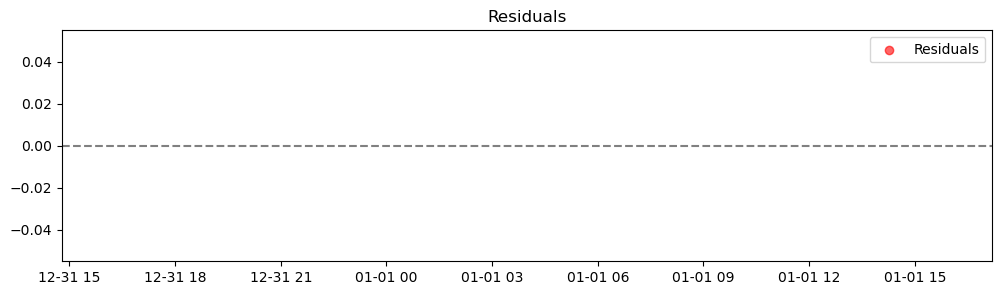

In [19]:
from statsmodels.tsa.seasonal import MSTL

res = MSTL(train_X_kWh_log, periods=(24, 24*7)).fit()
# Komponenten aus dem res-Objekt extrahieren
observed = res.observed
trend = res.trend
seasonal = res.seasonal
residuals = res.resid

# Plot für die beobachteten Daten
plt.figure(figsize=(12, 3))
plt.plot(observed, label='Observed', color='black')
plt.title('Observed')
plt.legend()

# Plot für den Trend
plt.figure(figsize=(12, 3))
plt.plot(trend, label='Trend', color='blue')
plt.title('Trend')
plt.legend()

# Plot für jede saisonale Komponente
for col in seasonal.columns:
    plt.figure(figsize=(12, 3))
    plt.plot(seasonal[col], label=f'Seasonal {col}', color='green')
    plt.title(f'Seasonal Component: {col}')
    plt.legend()

# Plot für die Residuen
plt.figure(figsize=(12, 3))
plt.scatter(residuals.index, residuals, label='Residuals', color='red', alpha=0.6)
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residuals')
plt.legend()
plt.show()



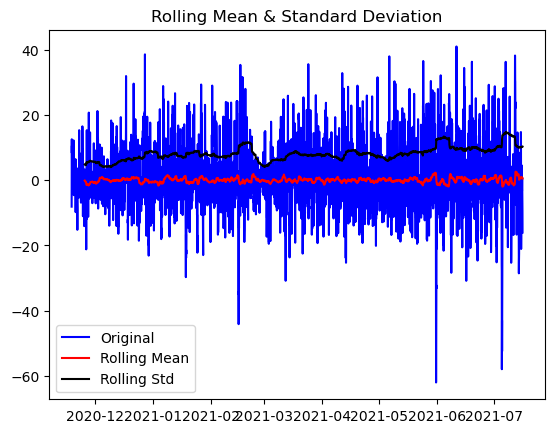

Results of Dickey-Fuller Test:

Test Statistic                -11.323611
p-value                              0.0
#Lags Used                         168.0
Number of Observations Used       5584.0
Critical Value (1%)              -3.4315
Critical Value (5%)              -2.8621
Critical Value (10%)             -2.5670
dtype: object


In [ ]:
test_stationarity(residuals)

### 2.2 ARIMA Model and Forecasting

In [28]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Vorhersage des Trends
trend_forecast = np.linspace(trend.iloc[-1], trend.iloc[-1] + (trend.iloc[-1] - trend.iloc[-2]), len(test_X_kWh))

# Vorhersage der Saisonalitäten:
seasonal_forecast = np.zeros(len(test_X_kWh))
for i in range(seasonal.shape[1]): # Iteriere durch die Saisonkomponenten
    seasonal_component = seasonal.iloc[:, i].values
    period = [24, 24*7][i] #Entsprechende Periode der Saisonkomponente
    seasonal_forecast += np.tile(seasonal_component[-period:], len(test_X_kWh) // period + 1)[:len(test_X_kWh)]

#Anpassen eines ARIMA Modells an die Residuen (p,d,q müssen passend gewählt werden)
arima_model = ARIMA(residuals, order=(1,0,1), freq='h').fit()

#Vorhersage der Residuen
residuals_forecast = arima_model.forecast(steps=len(test_X_kWh))

# Kombinieren aller Komponenten
forecast_arima = trend_forecast + seasonal_forecast + residuals_forecast
forecast_arima = np.clip(forecast_arima, a_min=0, a_max=None) # set all negative values to 0

# Erstellen eines Pandas Series mit dem richtigen Index
forecast_arima_series = pd.Series(forecast_arima, index=test_X_kWh.index, name='Forecast ARIMA')

#Evaluierung der Ergebniss
rmse_arima = np.sqrt(mean_squared_error(test_X_kWh[1:], forecast_arima_series[1:]))
print(f"RMSE ARIMA: {rmse_arima}")

# Vergleich und Visualisierung
results_arima = pd.concat([test_X_kWh, forecast_arima_series], axis=1)
print(results_arima)


plt.figure(figsize=(12, 6))
plt.plot(test_X_kWh, label='Tatsächliche Werte')
plt.plot(forecast_arima_series, label='Vorhersage ARIMA')
plt.legend()
plt.title('Vergleich von Vorhersage (ARIMA) und tatsächlichen Werten')
# Vergleich und Visualisierung (begrenzt auf den ersten Monat mit plt.xlim)
start_date_plot = pd.to_datetime('2021-07-16')
end_date_plot = pd.to_datetime('2021-09-01')
plt.xlim(start_date_plot, end_date_plot) # Begrenzung der x-Achse

plt.show()

NameError: name 'test' is not defined

***
ab hier nur zum testen

In [9]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Korrekter Import
from sklearn.linear_model import LinearRegression

# # Vorhersage des Trends
trend_forecast = np.linspace(trend.iloc[-1], trend.iloc[-1] + (trend.iloc[-1] - trend.iloc[-2]), len(test_X_kWh))

# # Anpassen des linearen Regressionsmodells an den Trend
# trend_model = LinearRegression()
# trend_model.fit(train_X_kWh.values.reshape(-1, 1), trend.values.reshape(-1, 1)) # Reshape für sklearn erforderlich

# Vorhersage des Trends mit linearer Regression
# Erstelle Zeitstempel für den Testzeitraum
test_time = pd.Series(range(len(train_X_kWh), len(train_X_kWh) + len(test_X_kWh)), index=test_X_kWh.index)
trend_forecast = trend_model.predict(test_time.values.reshape(-1, 1)).flatten() # Reshape und flatten für korrekte Form


# Vorhersage der Saisonalitäten:
seasonal_forecast = np.zeros(len(test_X_kWh))
for i in range(seasonal.shape[1]): # Iteriere durch die Saisonkomponenten
    seasonal_component = seasonal.iloc[:, i].values  # <- Korrektur: .iloc + .values

    period = [24, 24*7][i] #Entsprechende Periode der Saisonkomponente
    seasonal_forecast += np.tile(seasonal_component[-period:], len(test_X_kWh) // period + 1)[:len(test_X_kWh)]

#Anpassen eines ARIMA Modells an die Residuen (p,d,q müssen passend gewählt werden)
arima_model = ARIMA(residuals, order=(1,0,1), freq='h').fit() # Hier musst du die Parameter (p, d, q) anpassen
#Vorhersage der Residuen
residuals_forecast = arima_model.forecast(steps=len(test_X_kWh))

# Kombinieren aller Komponenten
forecast_arima = trend_forecast + seasonal_forecast + residuals_forecast

# Erstellen eines Pandas Series mit dem richtigen Index
forecast_arima_series = pd.Series(forecast_arima, index=test_X_kWh.index, name='Forecast ARIMA')

# #Evaluierung der Ergebnisse (z.B. mit RMSE, MAE)
rmse_arima = np.sqrt(mean_squared_error(test_X_kWh[1:], forecast_arima_series[1:]))
# mae_arima = mean_absolute_error(test_X_kWh, forecast_arima_series)
#
print(f"RMSE ARIMA: {rmse_arima}")
# print(f"MAE ARIMA: {mae_arima}")

# Vergleich und Visualisierung
results_arima = pd.concat([test_X_kWh, forecast_arima_series], axis=1)
print(results_arima)

plt.figure(figsize=(12, 6))
plt.plot(test_X_kWh, label='Tatsächliche Werte')
plt.plot(forecast_arima_series, label='Vorhersage ARIMA')
plt.legend()
plt.title('Vergleich von Vorhersage (ARIMA) und tatsächlichen Werten')

# Vergleich und Visualisierung (begrenzt auf den ersten Monat mit plt.xlim)
start_date_plot = pd.to_datetime('2021-07-01')
end_date_plot = pd.to_datetime('2021-08-01')
# plt.xlim(start_date_plot, end_date_plot) # Begrenzung der x-Achse

plt.show()


NameError: name 'trend_model' is not defined

***

## 3 Neural Network